NOTE:  If you get error messages like `IOPub message rate exceeded.` while running this notebook, close your Jupyter instance and restart it adding the option `--NotebookApp.iopub_data_rate_limit=1.0e10`.  (As instructed [here](https://stackoverflow.com/a/44679222)).  Also try `--NotebookApp.iopub_msg_rate_limit=1.0e10`.

# Homework 3: Monte Carlo

In this assignment you will implement on-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. You will apply both of these algorithms on the frozen lake and blackjack environments and visualize their performance.

In [2]:
import copy
import itertools as itt
from collections import defaultdict
from queue import deque
import ipdb

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

### Setup the Environment

This assignment uses two OpenAI gym environments: the frozen lake environment and the blackjack environment. Frozen lake is a grid world where the agent must reach a goal state while avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/), and the full description of blackjack [here](https://gym.openai.com/envs/Blackjack-v0/).  The blackjack implementation is the same as described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html).

In [3]:
env_blackjack = BlackjackEnv()
env_frozen_lake = FrozenLakeEnv(desc=None, map_name="4x4", is_slippery=False)

### Exercise 1 (5 pts):

Implement e-greedy action selection based on the current Q-values. Break ties between equal Q-values randomly. Remember an action should be a number in the range: [0, num_actions - 1].

In [4]:
def select_action_epsilon_greedy(Q_array, *, eps):
    """Perform epsilon greedy action selection based on the Q-values.
    
    Args:
        Q_array: A numpy array that contains Q-values relative to a single state.
        eps: The probability to select a random action. Float between 0 and 1.
    
    Returns:
        The selected action as an integer.
        
    Shapes:
        Q_array: `(A,)` where `A` is the number of actions.
        output: Scalar.
    """
    assert Q_array.ndim == 1
    templist = []
    
    #  YOUR CODE HERE:  select an action using the epsilon-greedy strategy, split ties randomly.
    if np.random.random() > eps: 
        for i in range(0, len(Q_array)):
            if Q_array[i] == np.max(Q_array):
                templist.append(i)
                       # greedy policy
        action = random.choice(templist)
#         action = random.choice(np.nonzero(Q_array == np.max(Q_array))[0])
    else:    # random policy
        action = random.randint(0, len(Q_array) - 1)
    return action

Implement a procedure which samples and returns a trajectory from the environment, using the epsilon-greedy agent.  The trajectory is represented by a list of (state, action, reward) tuples.

In [5]:
def sample_episode(env, Q, *, eps):
    """Sample an episode from the environment, using an epsilon-greedy policy based on Q.
    
    Args:
        env: The environment from which to sample episodes.
        Q: A dictionary mapping state -> action values array.
        eps: The epsilon-greedy parameter.
    
    Returns:
        transitions: A list of (state, action, reward) tuples describing the episode.
        
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
    """
    transitions = []  # store (state, action, reward) tuples here

    # YOUR CODE HERE:  sample an episode and store it in the transitions list.
    # NOTE: the Gym interface will require you to use the following methods
    # state = env.reset()  # initialize environment and get initial state
    # state_next, reward, done, info = env.step(action)  # perform action and receive next state, reward, done flag, and additional information.
    
    # ADVICE:  have a close look at what the state is (types and values), for both problems.
    
    state = env.reset()
#     done = False
    while True:
        action = select_action_epsilon_greedy(Q[state], eps=eps)
        state_next, reward, done, info = env.step(action)
        transitions.append((state, action, reward))
        state = state_next
        if done:
            break
    
    return transitions

### Exercise 2 (10 pts):

Implement the on-policy every-visit Monte Carlo update using the incremental update formula in Section 2.3 in SB. Recall that in Chapter 2 we averaged the *rewards* whereas in MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{equation}
    Q_{n+1} = Q_n + \alpha_n [G_n - Q_n]
\end{equation}
$$

In [6]:
def on_policy_every_visit_mc_control(env, num_episodes, *, eps, gamma):
    """Train an on-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0.0 and 1.0.     
        gamma: The discount factor.
        
    Returns:
        Q: a dictionary mapping state -> action values array.
        returns: an array containing the returns obtained for each episode during training.
    
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
        returns: `(E,)` where E is the number of episodes we are using to train the agent.
    """
    
    # NOTE:  The pseudo-code in the book explicitly stores lists of returns for each (s,a) pair.
    # We want to be more memory-efficient;  so we will store counts `C` for each (s,a) pair, and use
    # the update rule in SB 2.3 to compute the same average, without having to store all the returns.

    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))

    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)  # progress bar
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode, and use the transition list to compute returns and update Q and C.
        
        transitions = sample_episode(env, Q, eps=eps)    # store (state, action, reward) tuples here
        for trans in reversed(transitions):
            state, action, reward = trans[0], trans[1], trans[2]
            G = reward + gamma * G
            C[state][action] += 1
            alpha_n = 1 / C[state][action]
            Q[state][action] += alpha_n * (G - Q[state][action])
        
        returns[i] = G
        
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
        
    return Q, returns

### Exercise 3 (15 pts):

a) (2 pts) Calculate the learning curve (or returns) for the frozen lake environment, averaged over 50 independent runs and 1k episodes each, using $\gamma = 1.0$ and $\epsilon = 0.5$.

In [10]:
num_runs, num_episodes = 50, 1_000
returns_fl1 = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    Q, returns = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, eps=0.5, gamma=1.0)
    returns_fl1[i] = returns

b) (3 pts) Plot the resulting learning curve, averaging over the 50 runs, for the frozen lake environment.  If the results are noisy, use the following function to also plot, in the same figure, a smoother version of the same data.  Use these plots as a basis to find a better $\epsilon$ parameter, which makes the performance converge better.

In [7]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.
    
    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window
        
    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

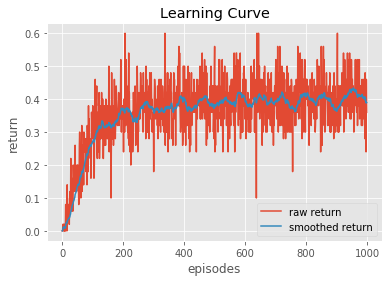

In [14]:
# YOUR CODE HERE

returns_fl_mean1 = returns_fl1.mean(0)
plt.plot(returns_fl_mean1, alpha=1)
plt.plot(rolling_average(returns_fl_mean1, window_size=25))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

In [15]:
num_runs, num_episodes = 50, 1_000
returns_fl2 = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    Q, returns = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, eps=0.05, gamma=1.0)
    returns_fl2[i] = returns

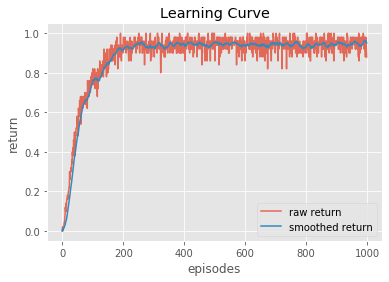

In [16]:
# YOUR CODE HERE

returns_fl_mean2 = returns_fl2.mean(0)
plt.plot(returns_fl_mean2, alpha=0.8)
plt.plot(rolling_average(returns_fl_mean2, window_size=15))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

c) (5 pts) Compute and plot the learning curve for the blackjack environment, this time averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.

In [17]:
num_runs, num_episodes = 50, 5_000
returns_bj1 = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    Q, returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=0.5, gamma=1.0)
    returns_bj1[i] = returns

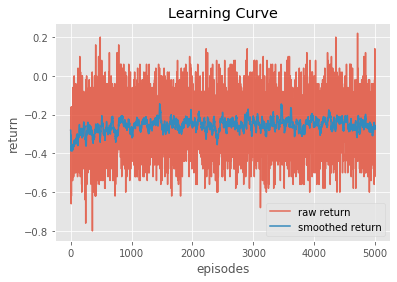

In [18]:
# YOUR CODE HERE

returns_bj_mean1 = returns_bj1.mean(0)
plt.plot(returns_bj_mean1, alpha=0.8)
plt.plot(rolling_average(returns_bj_mean1, window_size=25))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

In [19]:
num_runs, num_episodes = 50, 5_000
returns_bj2 = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    Q, returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=0.05, gamma=1.0)
    returns_bj2[i] = returns

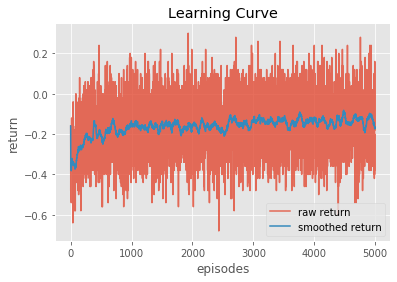

In [20]:
# YOUR CODE HERE

returns_bj_mean2 = returns_bj2.mean(0)
plt.plot(returns_bj_mean2, alpha=0.8)
plt.plot(rolling_average(returns_bj_mean2, window_size=50))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

d) (2 pts) In both environments, the learning curve can be relatively noisy, even after we have supposedly converged to the semi-optimal policy.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why is it possible that the learning curve does not converge to a fixed value even if the policy itself has converged?

**YOUR ANSWER HERE**

_1, Because we used on-policy, the Curve can finally converge to (1-epsilon)*G, but it will first go through a more noisy process.
2, Because we applied a stochastic policy, the epsilon probability to choose random policy will lead to random terminal states._

e) (3 pts) You may have noticed that, sometimes, the second half of a run is relatively faster than the first half.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why does this make sense?  For which types of domains does this make sense?  Can the opposite also make sense (i.e. that the second half of a run runs slower than the first run)?  For which types of domains does this make sense?

**YOUR ANSWER HERE**

_At the beginning, the agent knows little about the environment, so it will randomly explore the environment to learn, so it will run through a ramdom trajectory. In FrozenLake and BlackJack environments, the optimal trajectory is shorter. So in the second half run, the agent learned and got close to the optimal policy, which will take shorter time to run.
On the other hand, if the environment changes making the trajectory of optimal policy longer than other trajectory, the second half run will take more time._

### Exercise 4 (10 pts):

Run your code up to 500k episodes for the blackjack domain with a step size parameter that enables the value function to converge. Plot the value function as a color plot with a similar layout to that shown in SB Figure 5.2.  If convenient, use the given `plot_surface` function, creates a 3D plot given matrices X and Y representing the 2D function domain, and matrix Z representing the function value at those domain inputs.

In [21]:
def plot_surface(X, Y, Z, title):
    """Plot a 3d surface.

    Args:
        X: 2-d numpy.array indicating X positions (first input to the 3-d curve).
        Y: 2-d numpy.array indicating Y positions (second input to the 3-d curve).
        Z: 2-d numpy.array indicating Z positions (value of the 3-d curve).
        title: title of the plot
    """
    fig = plt.figure(figsize=(20, 10))
    ax = Axes3D(fig)
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        vmin=-1.0,
        vmax=1.0,
    )
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()


num_episodes = 500_000

# YOUR CODE HERE

Q, _ = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps = 0.05, gamma = 1.0)
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

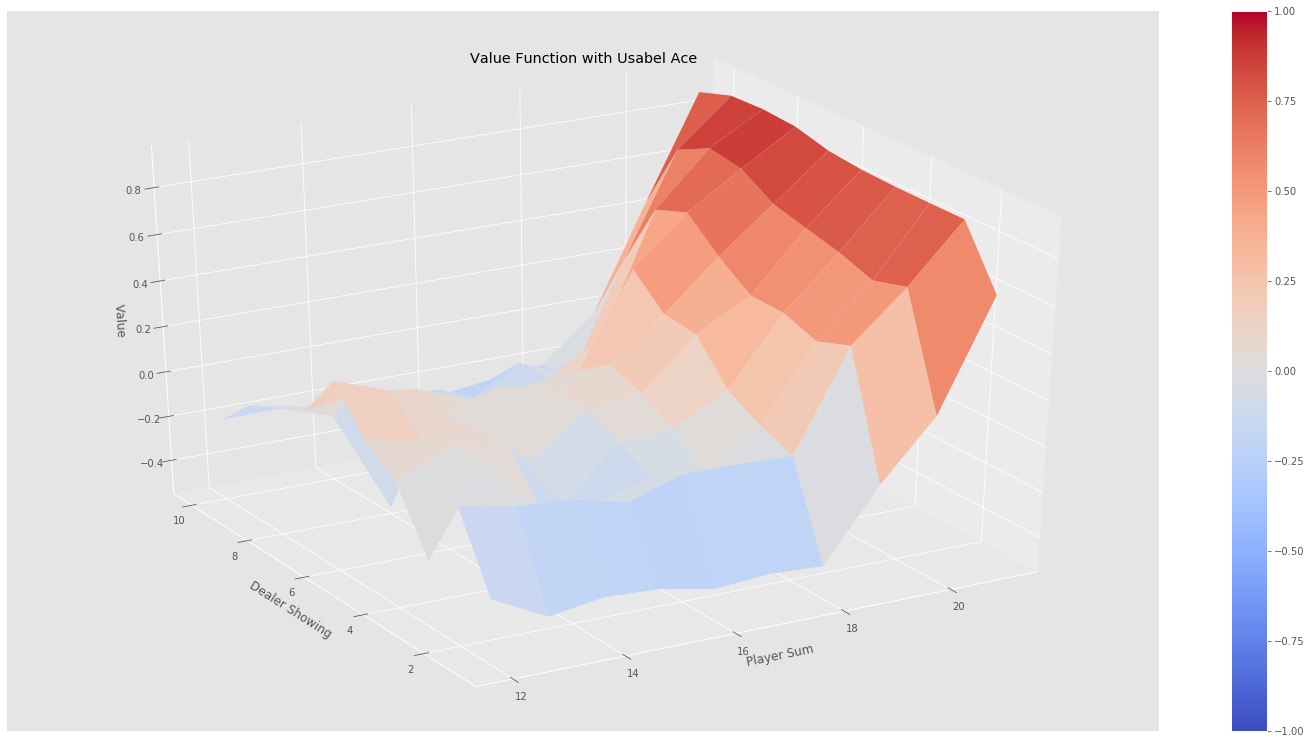

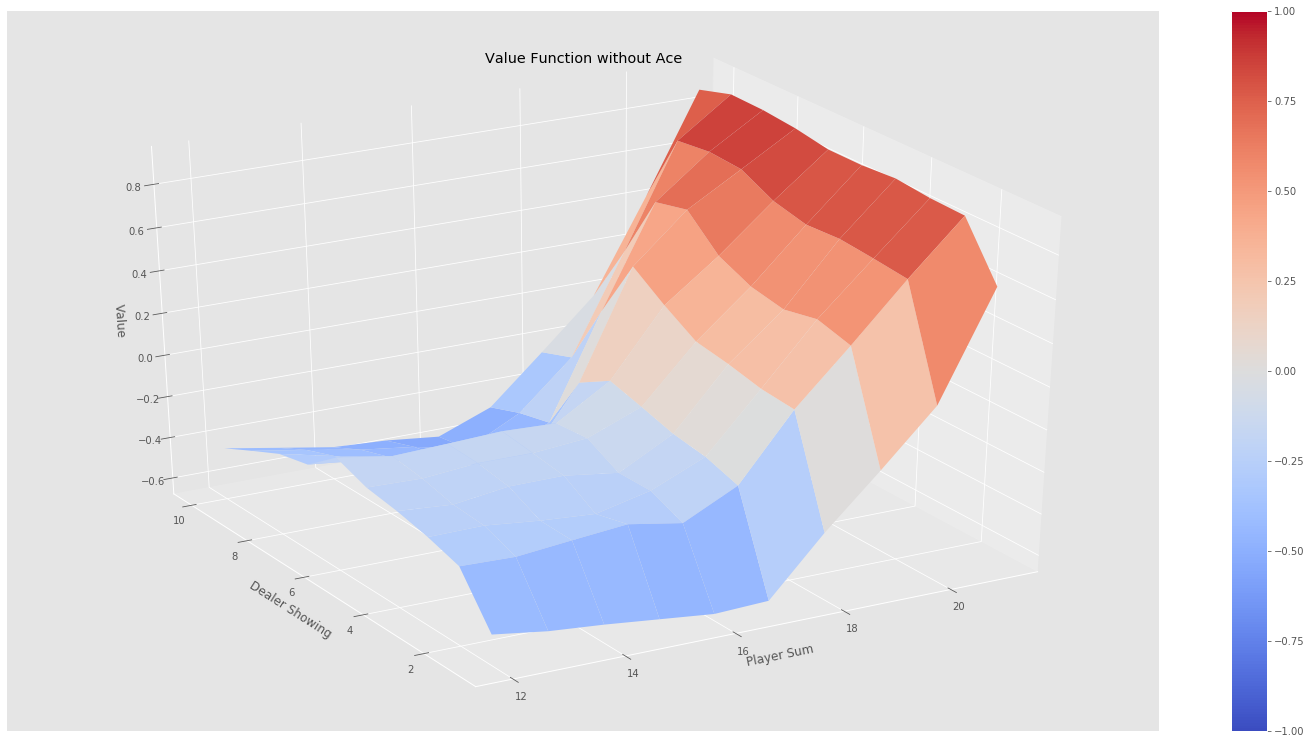

In [22]:
X, Y = np.meshgrid(np.arange(12, 22), np.arange(1, 11))
ace = np.zeros((10, 10))
N_ace = np.zeros((10, 10))
for dealer in np.arange(1, 11):
    for player in np.arange(12, 22):
        ace[dealer - 1][player - 12] = np.max(Q[(player, dealer, True)])
        N_ace[dealer - 1][player - 12] = np.max(Q[(player, dealer, False)])

plot_surface(X, Y, ace, 'Value Function with Usabel Ace')
plot_surface(X, Y, N_ace, 'Value Function without Ace')

### Exercise 5 (10 pts):

Implement the below function to train an off-policy every-visit MC agent which uses weighted importance sampling. As before, the behavior policy should be the epsilon greedy action selection.

In [8]:
def off_policy_every_visit_is_control(env, num_episodes, *, eps, gamma):
    '''
    Trains an off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes for which to train the agent.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        
    Returns:
        Q is a dictionary mapping state -> action values array.
        returns is a list containing the rewards obtained for each episode during training.
    '''
    
    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))
    policy = defaultdict(int)
    
    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        W = 1
        transitions = sample_episode(env, Q, eps = eps)
        Q_behavior = copy.deepcopy(Q)
        
        for trans in reversed(transitions):
            state, action, reward = trans[0], trans[1], trans[2]
            G = reward + gamma * G
            C[state][action] += W
            alpha_n = W / C[state][action]
            Q[state][action] += alpha_n * (G - Q[state][action])
            policy[state] = np.argmax(Q[state])
            if action != policy[state]: break
            B_S_A = compute_pi(Q_behavior[state], action, eps)
            W *= 1 / B_S_A            
        
        returns[i] = G        
     
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
            
    return Q, returns

# I don't know how to get this?
def compute_pi(Q, action, eps):
    if Q[action] != np.max(Q):
        return eps / len(Q)
    
    num_max = np.sum(Q == np.max(Q))
    return 1 - eps + num_max * (eps / len(Q))

### Exercise 6 (20 pts):

a) (5pts) Compute and plot the learning curve weighted importance sampling in the blackjack environment, averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.  Compare the results to those shown in exercise (3c).

In [9]:
num_runs, num_episodes = 10, 5_000

returns_mc = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (MC)'):
    # YOUR CODE HERE
    Q, returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, eps=0.5, gamma=1.0)
    returns_mc[i] = returns
    


In [10]:
returns_is = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    Q, returns = off_policy_every_visit_is_control(env_blackjack, num_episodes, eps=0.5, gamma=1.0)
    returns_is[i] = returns

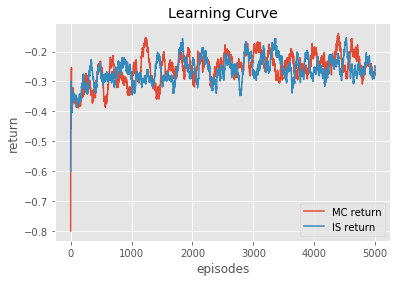

In [11]:
# YOUR CODE HERE
returns_mc_mean = returns_mc.mean(0)
returns_is_mean = returns_is.mean(0)

# plt.plot(returns_mc_mean, alpha=0.8)
# plt.plot(returns_is_mean, alpha=0.8)

plt.plot(rolling_average(returns_mc_mean, window_size=80))
plt.plot(rolling_average(returns_is_mean, window_size=80))
plt.legend(['MC return', 'IS return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

b) (5 pts) Now implement Monte Carlo Evaluation for the greddy policy of a Q function.

In [12]:
def on_policy_mc_evaluation(env, Q, num_episodes, *, gamma):
    '''
    Monte Carlo policy Evaluation.
    
    Args:
        env: The environment to train the agent on.
        Q is a dictionary mapping state -> action values array.
        num_episodes: The number of episodes for which to evaluate the agent.
        gamma: The discount factor.
        
    Returns:
        returns is a list containing the rewards obtained for each episode.
    '''
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        transitions = sample_episode(env, Q, eps=eps)    # store (state, action, reward) tuples here
        for trans in reversed(transitions):
            state, action, reward = trans[0], trans[1], trans[2]
            G = reward + gamma * G
            C[state][action] += 1
            alpha_n = 1 / C[state][action]
            Q[state][action] += alpha_n * (G - Q[state][action])
            
        returns[i] = G
        pbar.set_description(f'Episodes G={G}')
            
    return returns

c) (5 pts) Now run off-policy every-visit Importance Sampling control for 50 runs and 10k episodes, with $\epsilon = 0.1$, and plot the returns as you did previously.  Then, evaluate the Q function obtained by one of the 50 runs using the on-policy evaluation function, and print the resulting returns' mean and standard deviation.

In [13]:
num_runs, num_episodes = 10, 10_000

returns_is1 = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    # YOUR CODE HERE
    Q, returns = off_policy_every_visit_is_control(env_blackjack, num_episodes, eps=0.1, gamma=1.0)
    returns_is1[i] = returns
# YOUR CODE HERE

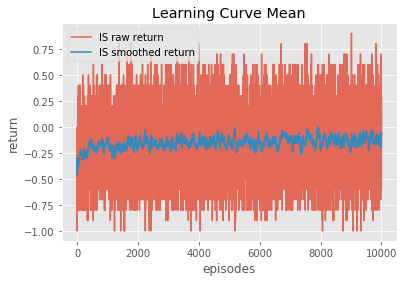

In [14]:
# Plotting
# returns_mc_mean = returns_mc.mean(0)
returns_is_mean1 = returns_is1.mean(0)
# returns_is_std = returns_is.std(0)
# plt.plot(returns_mc_mean, alpha=0.8)
plt.plot(returns_is_mean1, alpha=0.8)

# plt.plot(rolling_average(returns_mc_mean, window_size=25))
plt.plot(rolling_average(returns_is_mean1, window_size=50))
plt.legend(['IS raw return', 'IS smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve Mean')
plt.show()

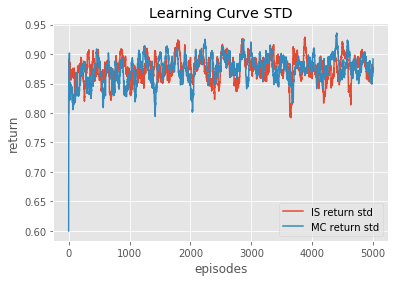

In [15]:
# returns_mc_mean = returns_mc.mean(0)
# returns_is_mean = returns_is.mean(0)
returns_is_std = returns_is.std(0)
returns_mc_std = returns_mc.std(0)
# plt.plot(returns_mc_mean, alpha=0.8)
# plt.plot(returns_is_std, alpha=0.8)

# plt.plot(rolling_average(returns_mc_mean, window_size=25))
plt.plot(rolling_average(returns_is_std, window_size=50))
plt.plot(rolling_average(returns_mc_std, window_size=50))
plt.legend(['IS return std', 'MC return std'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve STD')
plt.show()

d) **[graduate]** (5 pts) Do the mean and std match what is shown in the plot you got in exercise (6a)?  If not, explain why they are different.

**YOUR ANSWER HERE**

_They don't match. Because MC is ordinary importance sampling and IS is weighted importance sampling. Ordinary importance sampling will have larger STD because Q value will vary greatly. _